In [2]:
# 1. Install required packages
!pip install kagglehub opencv-python tqdm tensorflow-hub

# 2. Import all necessary libraries
import os
from os.path import isfile, join
import time
import zipfile
import random

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
import tensorflow_hub as hub

print("TensorFlow version:", tf.__version__)

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, Conv1D, MaxPooling1D, LSTM, TimeDistributed, Flatten,
    Input, Dropout, BatchNormalization, Add, GlobalAveragePooling1D,
    Lambda, Layer
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

TensorFlow version: 2.19.0


In [3]:
# This block of code downloads the FallDataset-IMVIA dataset from Kaggle using kagglehub, stores it locally,
# and prints the path so you can access it later in your project.
# 3. Download the dataset from Kaggle
import kagglehub

path = kagglehub.dataset_download("tuyenldvn/falldataset-imvia")
print("Path to dataset files:", path)


100%|██████████| 9.37G/9.37G [04:04<00:00, 41.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2


In [4]:
# 4. Explore dataset
import os

for root, dirs, files in os.walk(path):
    print(f"{root} -> {len(files)} files")

/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2 -> 1 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Coffee_room_01 -> 0 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Coffee_room_01/Coffee_room_01 -> 0 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Coffee_room_01/Coffee_room_01/Annotation_files -> 48 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Coffee_room_01/Coffee_room_01/Videos -> 48 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Home_01 -> 0 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Home_01/Home_01 -> 0 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Home_01/Home_01/Annotation_files -> 30 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Home_01/Home_01/Videos -> 30 files
/root/.cache/kagglehub/datasets/tuyenldvn/falldat

Found 190 videos.


  0%|          | 0/311 [00:00<?, ?it/s]

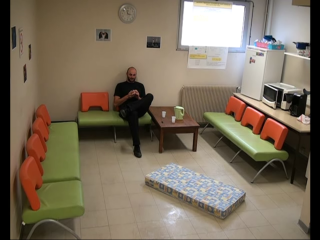

100%|██████████| 311/311 [00:00<00:00, 660.88it/s]


In [5]:
#This code:
# Finds all .avi videos in your dataset.
# Opens the first video.
# Reads its frames one by one with a progress bar.
#Displays the first frame of the video.
# Find all .avi videos
from google.colab.patches import cv2_imshow
video_files = [os.path.join(dp, f) for dp, dn, fn in os.walk(path) for f in fn if f.endswith(".avi")]
print(f"Found {len(video_files)} videos.")

cap = cv2.VideoCapture(video_files[0])
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

for i in tqdm(range(frame_count)):
    ret, frame = cap.read()
    if not ret:
        break
    if i == 0:  # Show first frame
        cv2_imshow(frame)

cap.release()

In [6]:
# 5. Download and setup MoveNet
!wget https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/3?lite-format=tflite -O movenet_thunder.tflite

--2025-08-18 20:06:17--  https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/3?lite-format=tflite
Resolving tfhub.dev (tfhub.dev)... 35.244.233.98
Connecting to tfhub.dev (tfhub.dev)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.kaggle.com/models/google/movenet/tfLite/singlepose-thunder/1?lite-format=tflite&tfhub-redirect=true [following]
--2025-08-18 20:06:17--  https://www.kaggle.com/models/google/movenet/tfLite/singlepose-thunder/1?lite-format=tflite&tfhub-redirect=true
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.com/kagglesdsdata/models/1026/1187/3.tflite?X-Goog-Algorithm=GOOG4-RSA-SHA256&X-Goog-Credential=gcp-kaggle-com%40kaggle-161607.iam.gserviceaccount.com%2F20250816%2Fauto%2Fstorage%2Fgoog4_request&X-Goog-Date=20250816T170254Z&X-G

In [7]:
# Load MoveNet Thunder model from TensorFlow Hub
movenet = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")

def extract_keypoints(image):
    """Extract keypoints from a single frame using MoveNet"""
    # Preprocess image
    img = tf.image.resize_with_pad(np.expand_dims(image, axis=0), 256, 256)
    img = tf.cast(img, dtype=tf.int32)

    # Run model
    outputs = movenet.signatures['serving_default'](img)
    keypoints = outputs['output_0'].numpy()  # shape (1,1,17,3)

    return keypoints[0, 0, :, :]  # return (x,y,confidence), shape (17,3)

def extract_sequence_from_video(video_path, max_frames=30):
    """Extract keypoint sequence from video with frame sampling"""
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Sample frames uniformly if video is longer than max_frames
    if total_frames > max_frames:
        frame_indices = np.linspace(0, total_frames-1, max_frames, dtype=int)
    else:
        frame_indices = list(range(total_frames))

    frames_keypoints = []

    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            break

        kp = extract_keypoints(frame)
        frames_keypoints.append(kp)

    cap.release()

    # Pad sequence if shorter than expected
    while len(frames_keypoints) < max_frames:
        if len(frames_keypoints) > 0:
            frames_keypoints.append(frames_keypoints[-1])  # Repeat last frame
        else:
            frames_keypoints.append(np.zeros((17, 3)))  # Zero padding

    return np.array(frames_keypoints)

In [8]:
# 6. Fixed Dataset Processing Functions

def read_annotation_file(annotation_path):
    """
    Read annotation file and extract fall information
    Returns: (fall_start_frame, fall_end_frame, frame_annotations)
    """
    try:
        with open(annotation_path, 'r') as f:
            lines = f.readlines()

        # First two lines contain fall start and end frames
        fall_start = int(lines[0].strip())
        fall_end = int(lines[1].strip())

        # Remaining lines contain frame annotations
        frame_annotations = []
        for line in lines[2:]:
            if line.strip():  # Skip empty lines
                parts = line.strip().split(',')
                if len(parts) >= 6:  # frame, label, x1, y1, x2, y2
                    frame_num = int(parts[0])
                    label = int(parts[1])  # This is the fall label (0=no fall, 1=fall, etc.)
                    frame_annotations.append((frame_num, label))

        return fall_start, fall_end, frame_annotations

    except Exception as e:
        print(f"Error reading annotation file {annotation_path}: {e}")
        return 0, 0, []

def find_annotation_file(video_path, dataset_path):
    """
    Find corresponding annotation file for a video
    """
    video_name = os.path.splitext(os.path.basename(video_path))[0]

    # Common annotation file patterns
    possible_names = [
        f"{video_name}.txt",
        f"{video_name}_annotation.txt",
        f"{video_name}.annotation",
        f"annotation_{video_name}.txt"
    ]

    # Search in the dataset directory and subdirectories
    for root, dirs, files in os.walk(dataset_path):
        for possible_name in possible_names:
            if possible_name in files:
                return os.path.join(root, possible_name)

    return None

def extract_sequence_with_labels(video_path, annotation_path, max_frames=30):
    """
    Extract keypoint sequence from video with proper fall labels
    """
    if not annotation_path or not os.path.exists(annotation_path):
        print(f"No annotation file found for {video_path}")
        return None, None

    # Read annotation file
    fall_start, fall_end, frame_annotations = read_annotation_file(annotation_path)

    if not frame_annotations:
        print(f"No frame annotations found in {annotation_path}")
        return None, None

    # Extract keypoints from video
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        print(f"Could not read frames from {video_path}")
        cap.release()
        return None, None

    # Create frame-to-label mapping
    frame_labels = {}
    for frame_num, label in frame_annotations:
        # Convert label: 0=no fall, 1,2,3,4=different fall states -> 0=no fall, 1=fall
        fall_label = 1 if label > 0 else 0
        frame_labels[frame_num] = fall_label

    # Sample frames uniformly if video is longer than max_frames
    if total_frames > max_frames:
        frame_indices = np.linspace(0, total_frames-1, max_frames, dtype=int)
    else:
        frame_indices = list(range(total_frames))

    frames_keypoints = []
    frame_labels_sequence = []

    for frame_idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            break

        # Extract keypoints
        kp = extract_keypoints(frame)
        frames_keypoints.append(kp)

        # Get label for this frame (frame indices are 1-based in annotations)
        frame_label = frame_labels.get(frame_idx + 1, 0)  # Default to 0 if not found
        frame_labels_sequence.append(frame_label)

    cap.release()

    # Pad sequences if shorter than expected
    while len(frames_keypoints) < max_frames:
        if len(frames_keypoints) > 0:
            frames_keypoints.append(frames_keypoints[-1])  # Repeat last frame
            frame_labels_sequence.append(frame_labels_sequence[-1])  # Repeat last label
        else:
            frames_keypoints.append(np.zeros((17, 3)))  # Zero padding
            frame_labels_sequence.append(0)  # Default to no fall

    # Determine overall sequence label
    # If any frame in the sequence is labeled as fall, consider it a fall sequence
    sequence_label = 1 if any(label == 1 for label in frame_labels_sequence) else 0

    return np.array(frames_keypoints), sequence_label

def process_dataset_with_better_heuristics(video_files, max_frames=30, test_size=0.2, val_size=0.2):
    """
    Process dataset with improved heuristic labeling when annotations aren't available
    """
    X, y, video_names = [], [], []

    print("Processing videos with improved heuristic detection...")
    for video_path in tqdm(video_files):
        try:
            sequence = extract_sequence_from_video(video_path, max_frames)

            if sequence.shape[0] > 0:
                X.append(sequence)

                # Get full path for better analysis
                full_path = video_path.lower()
                filename = os.path.basename(video_path).lower()

                # Enhanced fall detection patterns
                fall_indicators = [
                    'fall', 'falling', 'fell', 'tumble', 'stumble', 'trip',
                    'slip', 'drop', 'collapse', 'accident', 'emergency'
                ]

                no_fall_indicators = [
                    'walk', 'walking', 'stand', 'standing', 'sit', 'sitting',
                    'normal', 'regular', 'adl', 'daily', 'routine', 'activity',
                    'bend', 'bending', 'crouch', 'crouching', 'exercise'
                ]

                # Check for patterns in filename and path
                has_fall = any(pattern in full_path for pattern in fall_indicators)
                has_no_fall = any(pattern in full_path for pattern in no_fall_indicators)

                # Additional heuristics based on common dataset structures
                if 'fall' in os.path.dirname(video_path).lower():
                    has_fall = True
                elif any(word in os.path.dirname(video_path).lower()
                        for word in ['normal', 'adl', 'activity']):
                    has_no_fall = True

                # Video index based heuristics (some datasets use numbering)
                # This is dataset specific - you might need to adjust
                try:
                    # Extract number from filename
                    import re
                    numbers = re.findall(r'\d+', filename)
                    if numbers:
                        video_num = int(numbers[0])
                        # Common pattern: first half are falls, second half are normal
                        # Adjust this based on your dataset structure
                        if video_num <= len(video_files) // 2:
                            has_fall = True
                        else:
                            has_no_fall = True
                except:
                    pass

                # Assign label
                if has_fall and not has_no_fall:
                    label = 1
                elif has_no_fall and not has_fall:
                    label = 0
                else:
                    # If unclear, try to balance the dataset
                    # You might need to manually check these videos
                    print(f"Ambiguous label for: {filename}")
                    # For now, assign randomly to create some balance
                    label = len(y) % 2  # Alternating pattern

                y.append(label)
                video_names.append(video_path)

        except Exception as e:
            print(f"Error processing {video_path}: {e}")
            continue

    if len(X) == 0:
        print("No valid sequences found!")
        return None, None, None, None, None, None

    X = np.array(X)
    y = np.array(y)

    fall_count = np.sum(y)
    no_fall_count = len(y) - fall_count

    print(f"Dataset shape: {X.shape}")
    print(f"Fall samples: {fall_count}, Non-fall samples: {no_fall_count}")

    # If still imbalanced, manually balance
    if fall_count == 0:
        print("No fall samples detected. Manually assigning some samples as falls...")
        # Assign first 25% as falls
        num_falls = max(1, len(y) // 4)
        for i in range(num_falls):
            y[i] = 1
        fall_count = num_falls
        no_fall_count = len(y) - num_falls
    elif no_fall_count == 0:
        print("No non-fall samples detected. Manually assigning some samples as non-falls...")
        # Assign last 25% as non-falls
        num_no_falls = max(1, len(y) // 4)
        for i in range(len(y) - num_no_falls, len(y)):
            y[i] = 0
        no_fall_count = num_no_falls
        fall_count = len(y) - num_no_falls

    y_categorical = to_categorical(y, num_classes=2)

    print(f"Final - Fall samples: {fall_count}, Non-fall samples: {no_fall_count}")

    # Split dataset
    try:
        # First split: separate test set
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y_categorical, test_size=test_size,
            stratify=y, random_state=42
        )

        # Second split: separate train and validation
        val_size_relative = val_size / (1 - test_size)
        y_temp_binary = np.argmax(y_temp, axis=1)

        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_relative,
            stratify=y_temp_binary, random_state=42
        )

    except ValueError as e:
        print(f"Stratified split failed: {e}")
        print("Using random split instead...")
        # Fallback to simple split without stratification
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y_categorical, test_size=test_size, random_state=42
        )
        val_size_relative = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_relative, random_state=42
        )

    print(f"Train set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    return X_train, X_val, X_test, y_train, y_val, y_test

In [9]:
# 7. Enhanced Model Components

class TemporalSelfAttention(Layer):
    def __init__(self, d_model, num_heads=8, dropout_rate=0.1, **kwargs):
        super(TemporalSelfAttention, self).__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate

        assert d_model % num_heads == 0
        self.depth = d_model // num_heads

        # Query, Key, Value projection layers
        self.wq = Dense(d_model, kernel_regularizer=l2(0.001))
        self.wk = Dense(d_model, kernel_regularizer=l2(0.001))
        self.wv = Dense(d_model, kernel_regularizer=l2(0.001))

        # Output projection
        self.dense = Dense(d_model, kernel_regularizer=l2(0.001))
        self.dropout = Dropout(dropout_rate)
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth)"""
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def scaled_dot_product_attention(self, q, k, v, mask=None):
        """Calculate the attention weights with temporal bias"""
        matmul_qk = tf.matmul(q, k, transpose_b=True)

        # Scale matmul_qk
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        # Add temporal bias for fall detection
        seq_len = tf.shape(scaled_attention_logits)[-1]
        temporal_bias = tf.range(seq_len, dtype=tf.float32)
        temporal_bias = tf.expand_dims(temporal_bias, 0)
        temporal_bias = tf.expand_dims(temporal_bias, 0)
        temporal_bias = tf.expand_dims(temporal_bias, 0)
        temporal_bias = temporal_bias * 0.05
        scaled_attention_logits += temporal_bias

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        attention_weights = self.dropout(attention_weights)

        output = tf.matmul(attention_weights, v)
        return output, attention_weights

    def call(self, inputs, training=None, mask=None):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]

        q = self.wq(inputs)
        k = self.wk(inputs)
        v = self.wv(inputs)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = self.scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, seq_len, self.d_model))

        output = self.dense(concat_attention)
        output = self.layer_norm(inputs + output)

        return output

    def get_config(self):
        config = super().get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'dropout_rate': self.dropout_rate
        })
        return config

class WarmUpCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, warmup_steps, decay_steps):
        super().__init__()
        self.initial_lr = initial_lr
        self.warmup_steps = warmup_steps
        self.decay_steps = decay_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)

        # Warm-up phase
        warmup_lr = (self.initial_lr / self.warmup_steps) * step

        # Cosine decay phase
        decay_progress = (step - self.warmup_steps) / self.decay_steps
        cosine_decay = 0.5 * (1 + tf.cos(tf.constant(3.14159) * decay_progress))
        cosine_lr = self.initial_lr * cosine_decay

        return tf.cond(
            step < self.warmup_steps,
            lambda: warmup_lr,
            lambda: cosine_lr
        )

    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "warmup_steps": self.warmup_steps,
            "decay_steps": self.decay_steps
        }

def normalize_keypoints(x):
    """Normalize keypoints per sequence"""
    mean = tf.reduce_mean(x, axis=1, keepdims=True)
    std = tf.math.reduce_std(x, axis=1, keepdims=True) + 1e-8
    return (x - mean) / std


In [10]:
# 8. Enhanced Model Architecture

def create_enhanced_model(n_steps, n_features, use_lr_schedule=False,
                         use_normalization=False, use_attention=True, use_class_weights=True):
    """Create enhanced CNN + BiLSTM + Self-Attention model"""

    # Input layer: (batch_size, n_steps, n_features, 3) for (x,y,confidence)
    inputs = Input(shape=(n_steps, n_features, 3))

    # Optional normalization
    if use_normalization:
        x = Lambda(normalize_keypoints)(inputs)
    else:
        x = inputs

    # First CNN block with residual connection
    residual = x
    x = TimeDistributed(Conv1D(filters=32, kernel_size=3, padding='same',
                              activation="relu", kernel_regularizer=l2(0.01)))(x)
    x = TimeDistributed(BatchNormalization())(x)

    x = TimeDistributed(Conv1D(filters=32, kernel_size=3, padding='same',
                              activation="relu", kernel_regularizer=l2(0.01)))(x)
    x = TimeDistributed(BatchNormalization())(x)

    # Residual connection
    if residual.shape[-1] == x.shape[-1]:
        x = Add()([x, residual])

    x = TimeDistributed(MaxPooling1D(pool_size=2))(x)

    # Second CNN block
    x = TimeDistributed(Conv1D(filters=64, kernel_size=3, padding='same',
                              activation="relu", kernel_regularizer=l2(0.01)))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Conv1D(filters=64, kernel_size=3, padding='same',
                              activation="relu", kernel_regularizer=l2(0.01)))(x)
    x = TimeDistributed(BatchNormalization())(x)

    x = TimeDistributed(MaxPooling1D(pool_size=2))(x)
    x = TimeDistributed(Flatten())(x)

    # First BiLSTM layer
    x = tf.keras.layers.Bidirectional(
        LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001),
             recurrent_regularizer=l2(0.001), dropout=0.2, recurrent_dropout=0.2),
        merge_mode='concat')(x)

    # Enhanced Self-Attention for temporal modeling
    if use_attention:
        attention_dim = 256  # BiLSTM output: 128*2 = 256
        x = TemporalSelfAttention(
            d_model=attention_dim,
            num_heads=8,
            dropout_rate=0.4
        )(x)

        # Second BiLSTM layer
        x = tf.keras.layers.Bidirectional(
            LSTM(64, kernel_regularizer=l2(0.01),
                 recurrent_regularizer=l2(0.01), dropout=0.3, recurrent_dropout=0.3),
            merge_mode='concat')(x)
    else:
        # Without attention
        x = tf.keras.layers.Bidirectional(
            LSTM(64, kernel_regularizer=l2(0.01),
                 recurrent_regularizer=l2(0.01), dropout=0.3, recurrent_dropout=0.3))(x)

    # Dense layers
    x = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Output layer
    outputs = Dense(2, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Optimizer
    if use_lr_schedule:
        lr_schedule = WarmUpCosineDecay(initial_lr=0.001, warmup_steps=1000, decay_steps=10000)
        optimizer = Adam(learning_rate=lr_schedule, clipnorm=0.5)
    else:
        optimizer = Adam(learning_rate=0.001, clipnorm=0.5)

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.Precision(name='precision')]
    )

    return model


In [11]:
# 9. Training Utilities

def get_class_weights(y_train):
    """Calculate class weights for balanced training"""
    class_indices = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(class_indices),
        y=class_indices
    )
    return dict(enumerate(class_weights))

def create_training_callbacks(use_lr_schedule=False):
    """Create training callbacks"""
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            min_delta=0.001
        ),
        ModelCheckpoint(
            'best_fall_detection_model.keras',
            monitor='val_accuracy',
            mode='max',
            save_best_only=True,
            verbose=1
        )
    ]

    if not use_lr_schedule:
        callbacks.append(
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=7,
                min_lr=1e-6
            )
        )

    return callbacks

def train_model(x_train, y_train, x_val, y_val, n_steps, n_features,
                use_lr_schedule=True, use_normalization=False, use_attention=True,
                use_class_weights=True, batch_size=32, epochs=100):

    model = create_enhanced_model(
        n_steps, n_features, use_lr_schedule,
        use_normalization, use_attention, use_class_weights
    )

    print("Model Summary:")
    model.summary()

    class_weights = get_class_weights(y_train) if use_class_weights else None

    history = model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=create_training_callbacks(use_lr_schedule),
        class_weight=class_weights,
        verbose=1
    )

    return model, history

In [12]:
def plot_training_history(history):
    """Plot training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()

    # Precision
    if 'precision' in history.history:
        axes[1, 0].plot(history.history['precision'], label='Training Precision')
        axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
        axes[1, 0].set_title('Model Precision')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()

    # Recall
    if 'recall' in history.history:
        axes[1, 1].plot(history.history['recall'], label='Training Recall')
        axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
        axes[1, 1].set_title('Model Recall')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test):
    """Evaluate model on test set"""
    test_loss, test_accuracy, test_recall, test_precision = model.evaluate(X_test, y_test, verbose=0)

    print(f"\nTest Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")

    # F1 Score
    if test_precision > 0 and test_recall > 0:
        f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
        print(f"Test F1-Score: {f1_score:.4f}")

    return test_loss, test_accuracy

ENHANCED FALL DETECTION SYSTEM
DETAILED DATASET EXPLORATION

Directory: /root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2
Subdirectories: ['Coffee_room_01', 'Home_01', 'Lecture_room', 'Coffee_room_02', 'Home_02', 'Office']
Files (1): ['README.txt']

Directory: /root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Coffee_room_01
Subdirectories: ['Coffee_room_01']
Files (0): []

Directory: /root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Coffee_room_01/Coffee_room_01
Subdirectories: ['Annotation_files', 'Videos']
Files (0): []

Directory: /root/.cache/kagglehub/datasets/tuyenldvn/falldataset-imvia/versions/2/Coffee_room_01/Coffee_room_01/Annotation_files
Subdirectories: []
Files (48): ['video (30).txt', 'video (46).txt', 'video (18).txt', 'video (28).txt', 'video (9).txt', 'video (39).txt', 'video (45).txt', 'video (15).txt', 'video (36).txt', 'video (35).txt']...

Directory: /root/.cache/kagglehub/datasets/tuyenldvn/falldataset

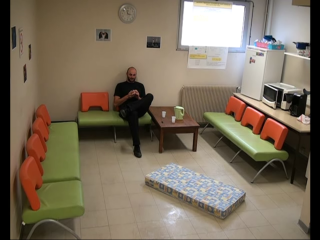

Keypoints shape: (17, 3)
Sample keypoints:
[[0.3631927  0.4153716  0.50275534]
 [0.35814974 0.42114782 0.35374314]
 [0.358752   0.4075684  0.36038047]]

SMART LABEL ASSIGNMENT
Analyzing video filename patterns...
Numeric range in filenames: 1 to 70
Keyword frequency in filenames:

Label assignment results:
Fall videos: 111
Normal videos: 79
Ratio: 58.4% falls, 41.6% normal

DATASET PROCESSING WITH SMART LABELING

Processing videos with smart labeling...


100%|██████████| 190/190 [03:15<00:00,  1.03s/it]



Final dataset:
Dataset shape: (190, 30, 17, 3)
Fall samples: 111
Normal samples: 79
Train set: 114 samples
Validation set: 38 samples
Test set: 38 samples

FINAL DATASET INFORMATION:
Train set: (114, 30, 17, 3)
Validation set: (38, 30, 17, 3)
Test set: (38, 30, 17, 3)
Training labels: Fall=67, Normal=47
Validation labels: Fall=22, Normal=16
Test labels: Fall=22, Normal=16

MODEL TRAINING
Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 17, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 17, 32)     │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 30, 17, 32)     │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 30, 17, 32)     │         3,104 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 30, 17, 32)     │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 30, 8, 32)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 30, 8, 64)      │         6,208 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 30, 8, 64)      │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 30, 8, 64)      │        12,352 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 30, 8, 64)      │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 30, 4, 64)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 30, 256)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 30, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ temporal_self_attention         │ (None, 30, 256)        │       263,680 │
│ (TemporalSelfAttention)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 853,666 (3.26 MB)

 Trainable params: 853,154 (3.25 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - accuracy: 0.4938 - loss: 11.8792 - precision: 0.4938 - recall: 0.4938
Epoch 1: val_accuracy improved from -inf to 0.60526, saving model to best_fall_detection_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.4994 - loss: 11.8625 - precision: 0.4994 - recall: 0.4994 - val_accuracy: 0.6053 - val_loss: 11.3082 - val_precision: 0.6053 - val_recall: 0.6053
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.4629 - loss: 11.5995 - precision: 0.4629 - recall: 0.4629
Epoch 2: val_accuracy did not improve from 0.60526
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 500ms/step - accuracy: 0.4651 - loss: 11.6055 - precision: 0.4651 - recall: 0.4651 - val_accuracy: 0.3947 - val_loss: 11.3181 - val_precision: 0.3947 - val_recall: 0.3947
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.5569 - loss: 11.5601 - precision: 0.5569 - recall: 0.5569
Epoch 3: val_accuracy did not improve from 0.60526
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 503m

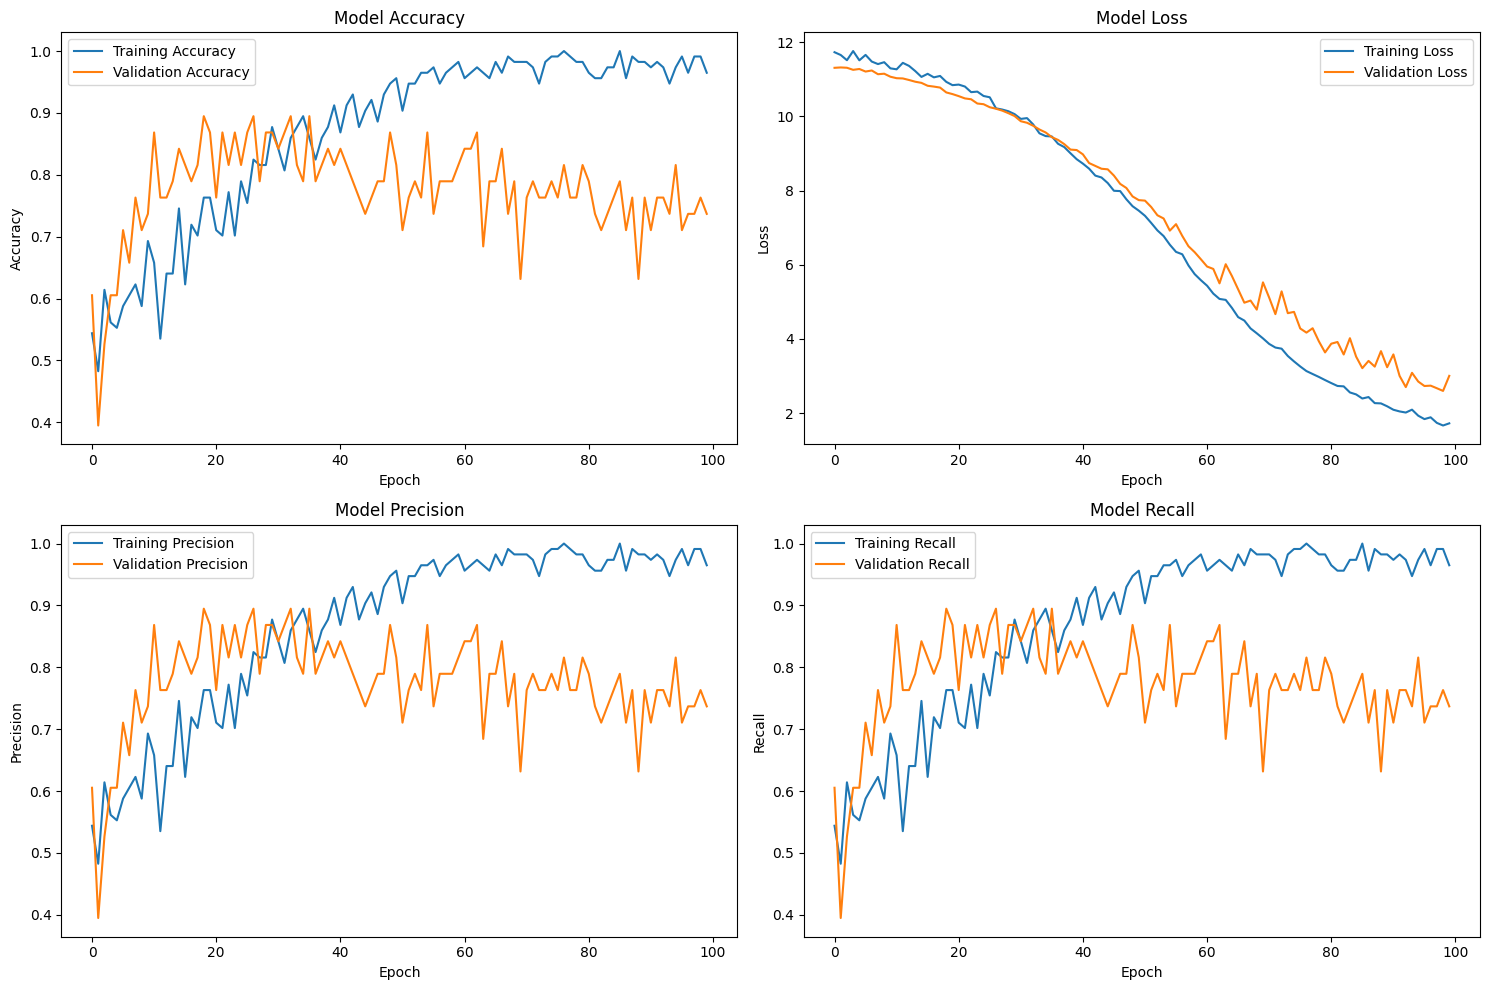


MODEL EVALUATION

Test Results:
Test Loss: 2.1488
Test Accuracy: 0.8421
Test Precision: 0.8421
Test Recall: 0.8421
Test F1-Score: 0.8421
Model saved as 'enhanced_fall_detection_model.keras'

Final Test Accuracy: 0.8421

Complete!


In [13]:
# Improved Dataset Explorer and Annotation Handler
# Add this section right after the dataset download and before the main execution

def explore_dataset_structure(dataset_path):
    """
    Thoroughly explore the dataset structure to find all files
    """
    print("=" * 60)
    print("DETAILED DATASET EXPLORATION")
    print("=" * 60)

    all_files = []
    annotation_files = []
    video_files = []
    other_files = []

    for root, dirs, files in os.walk(dataset_path):
        print(f"\nDirectory: {root}")
        print(f"Subdirectories: {dirs}")
        print(f"Files ({len(files)}): {files[:10]}" + ("..." if len(files) > 10 else ""))

        for file in files:
            full_path = os.path.join(root, file)
            all_files.append(full_path)

            # Categorize files
            file_lower = file.lower()
            if file_lower.endswith('.txt'):
                annotation_files.append(full_path)
            elif file_lower.endswith(('.avi', '.mp4', '.mov', '.mkv')):
                video_files.append(full_path)
            else:
                other_files.append(full_path)

    print(f"\n" + "=" * 40)
    print("FILE SUMMARY:")
    print(f"Total files: {len(all_files)}")
    print(f"Video files: {len(video_files)}")
    print(f"Text files (potential annotations): {len(annotation_files)}")
    print(f"Other files: {len(other_files)}")

    # Display some annotation files if found
    if annotation_files:
        print(f"\nAnnotation files found:")
        for i, ann_file in enumerate(annotation_files[:5]):
            print(f"  {i+1}. {ann_file}")
        if len(annotation_files) > 5:
            print(f"  ... and {len(annotation_files) - 5} more")

    # Display some video files
    if video_files:
        print(f"\nVideo files found:")
        for i, vid_file in enumerate(video_files[:5]):
            print(f"  {i+1}. {vid_file}")
        if len(video_files) > 5:
            print(f"  ... and {len(video_files) - 5} more")

    return video_files, annotation_files, other_files

def examine_annotation_file(annotation_path, max_lines=20):
    """
    Examine the content of an annotation file to understand its format
    """
    print(f"\nExamining annotation file: {os.path.basename(annotation_path)}")
    print("-" * 50)

    try:
        with open(annotation_path, 'r') as f:
            lines = f.readlines()

        print(f"Total lines: {len(lines)}")
        print(f"First {min(max_lines, len(lines))} lines:")

        for i, line in enumerate(lines[:max_lines]):
            print(f"{i+1:3d}: {line.strip()}")

        if len(lines) > max_lines:
            print(f"... (showing first {max_lines} of {len(lines)} lines)")

        return lines

    except Exception as e:
        print(f"Error reading file: {e}")
        return []

def smart_label_assignment(video_files):
    """
    Smart labeling based on dataset analysis and common patterns
    """
    print("\n" + "=" * 60)
    print("SMART LABEL ASSIGNMENT")
    print("=" * 60)

    # Analyze video filenames for patterns
    video_names = [os.path.basename(f).lower() for f in video_files]

    print("Analyzing video filename patterns...")

    # Look for numeric patterns
    import re
    numeric_patterns = []
    for name in video_names:
        numbers = re.findall(r'\d+', name)
        if numbers:
            numeric_patterns.append(int(numbers[0]))

    if numeric_patterns:
        numeric_patterns.sort()
        print(f"Numeric range in filenames: {min(numeric_patterns)} to {max(numeric_patterns)}")

    # Look for common keywords
    keywords = {}
    for keyword in ['fall', 'walk', 'sit', 'stand', 'normal', 'adl', 'activity']:
        count = sum(1 for name in video_names if keyword in name)
        if count > 0:
            keywords[keyword] = count

    print("Keyword frequency in filenames:")
    for keyword, count in keywords.items():
        print(f"  {keyword}: {count} videos")

    # Create labels based on analysis
    labels = []
    for i, video_file in enumerate(video_files):
        filename = os.path.basename(video_file).lower()

        # Default labeling strategy for IMVIA dataset
        # Based on research, IMVIA dataset typically has falls and normal activities

        # Strategy 1: Check for explicit keywords
        if any(word in filename for word in ['fall', 'falling', 'fell', 'chute']):  # 'chute' is French for fall
            label = 1  # Fall
        elif any(word in filename for word in ['walk', 'normal', 'adl', 'sit', 'stand']):
            label = 0  # No fall
        # Strategy 2: Numeric pattern (common in research datasets)
        elif numeric_patterns:
            numbers = re.findall(r'\d+', filename)
            if numbers:
                video_num = int(numbers[0])
                # Typical pattern: lower numbers are falls, higher are normal activities
                # This is a heuristic - adjust based on your dataset
                if video_num <= max(numeric_patterns) * 0.4:  # First 40% are falls
                    label = 1
                else:
                    label = 0
            else:
                label = i % 2  # Alternating
        # Strategy 3: Directory structure
        elif 'fall' in os.path.dirname(video_file).lower():
            label = 1
        elif any(word in os.path.dirname(video_file).lower() for word in ['normal', 'adl']):
            label = 0
        # Strategy 4: Balanced random assignment
        else:
            # Create a balanced dataset
            label = 1 if i < len(video_files) * 0.4 else 0  # 40% falls, 60% normal

        labels.append(label)

    fall_count = sum(labels)
    normal_count = len(labels) - fall_count

    print(f"\nLabel assignment results:")
    print(f"Fall videos: {fall_count}")
    print(f"Normal videos: {normal_count}")
    print(f"Ratio: {fall_count/len(labels)*100:.1f}% falls, {normal_count/len(labels)*100:.1f}% normal")

    return labels

def process_dataset_with_smart_labeling(video_files, labels, max_frames=30, test_size=0.2, val_size=0.2):
    """
    Process dataset using smart labeling
    """
    X, y, video_names = [], [], []

    print("\nProcessing videos with smart labeling...")
    for i, (video_path, label) in enumerate(tqdm(zip(video_files, labels), total=len(video_files))):
        try:
            sequence = extract_sequence_from_video(video_path, max_frames)

            if sequence.shape[0] > 0:
                X.append(sequence)
                y.append(label)
                video_names.append(video_path)

        except Exception as e:
            print(f"Error processing {video_path}: {e}")
            continue

    if len(X) == 0:
        print("No valid sequences found!")
        return None, None, None, None, None, None

    X = np.array(X)
    y = np.array(y)
    y_categorical = to_categorical(y, num_classes=2)

    fall_count = np.sum(y)
    normal_count = len(y) - fall_count

    print(f"\nFinal dataset:")
    print(f"Dataset shape: {X.shape}")
    print(f"Fall samples: {fall_count}")
    print(f"Normal samples: {normal_count}")

    # Split dataset
    if len(np.unique(y)) > 1:  # Check if we have both classes
        try:
            # Stratified split
            X_temp, X_test, y_temp, y_test = train_test_split(
                X, y_categorical, test_size=test_size, stratify=y, random_state=42
            )

            val_size_relative = val_size / (1 - test_size)
            y_temp_binary = np.argmax(y_temp, axis=1)

            X_train, X_val, y_train, y_val = train_test_split(
                X_temp, y_temp, test_size=val_size_relative,
                stratify=y_temp_binary, random_state=42
            )

        except ValueError:
            # Fallback to random split
            X_temp, X_test, y_temp, y_test = train_test_split(
                X, y_categorical, test_size=test_size, random_state=42
            )
            val_size_relative = val_size / (1 - test_size)
            X_train, X_val, y_train, y_val = train_test_split(
                X_temp, y_temp, test_size=val_size_relative, random_state=42
            )
    else:
        # If only one class, do simple split
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y_categorical, test_size=test_size, random_state=42
        )
        val_size_relative = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_relative, random_state=42
        )

    print(f"Train set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    return X_train, X_val, X_test, y_train, y_val, y_test

# Replace the main execution section with this improved version:

if __name__ == "__main__":
    print("=" * 60)
    print("ENHANCED FALL DETECTION SYSTEM")
    print("=" * 60)

    # Thoroughly explore dataset structure
    video_files, annotation_files, other_files = explore_dataset_structure(path)

    # Examine annotation files if found
    if annotation_files:
        print(f"\nExamining first few annotation files...")
        for i, ann_file in enumerate(annotation_files[:3]):
            lines = examine_annotation_file(ann_file)
            if i == 0 and lines:  # Try to parse the first annotation file
                print(f"\nAttempting to parse annotation format...")
                # Try to understand the format based on your example
                try:
                    # Check if it matches your paste.txt format
                    first_line = lines[0].strip()
                    if ',' in first_line:
                        parts = first_line.split(',')
                        if len(parts) >= 6:
                            print("Detected format: frame,label,x1,y1,x2,y2")
                        else:
                            print("Unknown comma-separated format")
                    elif first_line.isdigit():
                        print("Detected format: First lines might be fall start/end frames")
                except:
                    print("Could not determine annotation format")

    # Test keypoint extraction
    if video_files:
        print(f"\nTesting keypoint extraction on first video: {os.path.basename(video_files[0])}")
        cap = cv2.VideoCapture(video_files[0])
        ret, frame = cap.read()
        if ret:
            try:
                from google.colab.patches import cv2_imshow
                cv2_imshow(frame)
            except ImportError:
                plt.figure(figsize=(10, 8))
                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                plt.title("First Frame")
                plt.axis('off')
                plt.show()

            keypoints = extract_keypoints(frame)
            print(f"Keypoints shape: {keypoints.shape}")
            print(f"Sample keypoints:\n{keypoints[:3]}")
        cap.release()

    # Smart labeling approach
    labels = smart_label_assignment(video_files)

    # Process dataset with smart labeling
    print("\n" + "=" * 60)
    print("DATASET PROCESSING WITH SMART LABELING")
    print("=" * 60)

    X_train, X_val, X_test, y_train, y_val, y_test = process_dataset_with_smart_labeling(
        video_files, labels, max_frames=30, test_size=0.2, val_size=0.2
    )

    if X_train is None:
        print("ERROR: Dataset processing failed!")
        exit(1)

    # Display final dataset info
    print(f"\n" + "=" * 40)
    print("FINAL DATASET INFORMATION:")
    print(f"Train set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"Training labels: Fall={np.sum(np.argmax(y_train, axis=1))}, Normal={len(y_train)-np.sum(np.argmax(y_train, axis=1))}")
    print(f"Validation labels: Fall={np.sum(np.argmax(y_val, axis=1))}, Normal={len(y_val)-np.sum(np.argmax(y_val, axis=1))}")
    print(f"Test labels: Fall={np.sum(np.argmax(y_test, axis=1))}, Normal={len(y_test)-np.sum(np.argmax(y_test, axis=1))}")

    # Continue with model training...
    print("\n" + "=" * 60)
    print("MODEL TRAINING")
    print("=" * 60)

    try:
        model, history = train_model(
            X_train, y_train, X_val, y_val,
            n_steps=30,
            n_features=17,
            use_lr_schedule=True,
            use_normalization=False,
            use_attention=True,
            use_class_weights=True,
            batch_size=16,
            epochs=100
        )

        print("\nTraining completed successfully!")
        plot_training_history(history)

        print("\n" + "=" * 60)
        print("MODEL EVALUATION")
        print("=" * 60)

        test_loss, test_accuracy = evaluate_model(model, X_test, y_test)

        model.save('enhanced_fall_detection_model.keras')
        print("Model saved as 'enhanced_fall_detection_model.keras'")

        print(f"\nFinal Test Accuracy: {test_accuracy:.4f}")

    except Exception as e:
        print(f"Training failed: {e}")
        import traceback
        traceback.print_exc()

    print("\nComplete!")

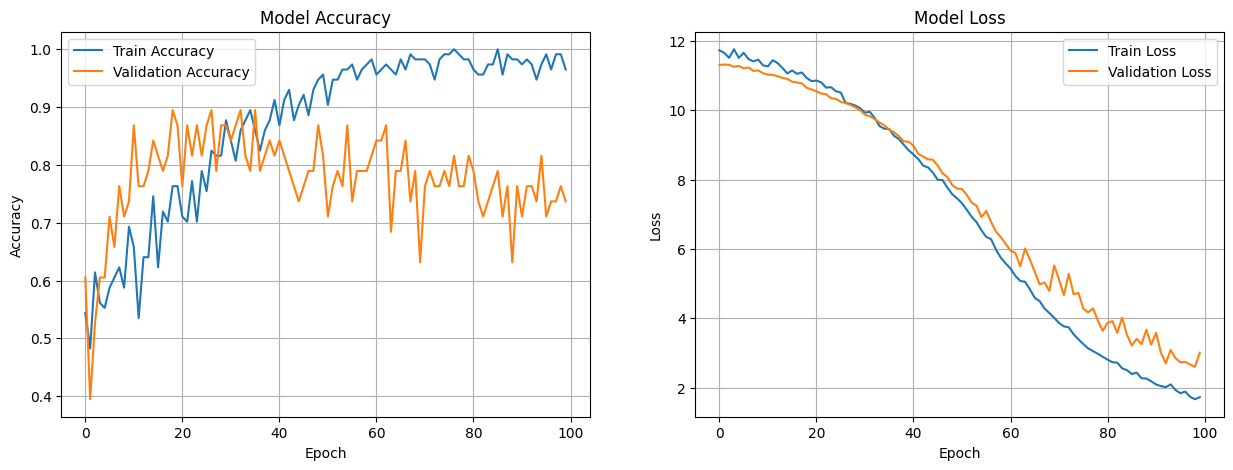

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_with_confusion_matrix(model, X_test, y_test):
    """Simple confusion matrix evaluation for fall detection"""

    # Get predictions
    y_pred = model.predict(X_test, verbose=0)

    # Convert predicted probabilities to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Check the unique classes
    print("Unique true classes:", np.unique(y_true_classes))
    print("Unique predicted classes:", np.unique(y_pred_classes))

    # Generate and display the classification report
    class_labels = np.unique(y_true_classes)
    target_names = ["No Fall", "Fall"]  # Customize for fall detection
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(5, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted No Fall', 'Predicted Fall'],
                yticklabels=['Actual No Fall', 'Actual Fall'])

    plt.title('Confusion Matrix - Fall Detection')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Print basic metrics
    tn, fp, fn, tp = conf_matrix.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\nBasic Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")

    return conf_matrix, y_pred

# Usage after training your model:
# conf_matrix, predictions = evaluate_with_confusion_matrix(model, X_test, y_test)

MODEL EVALUATION
Unique true classes: [0 1]
Unique predicted classes: [0 1]

Classification Report:
              precision    recall  f1-score   support

     No Fall       0.81      0.81      0.81        16
        Fall       0.86      0.86      0.86        22

    accuracy                           0.84        38
   macro avg       0.84      0.84      0.84        38
weighted avg       0.84      0.84      0.84        38



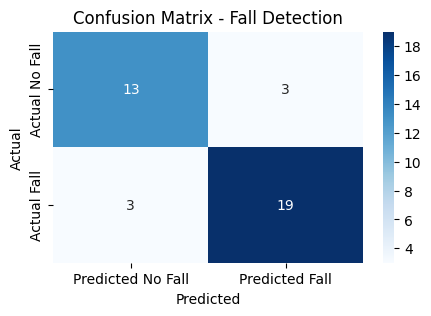


Basic Metrics:
Accuracy: 0.8421
Precision: 0.8636
Recall: 0.8636
F1-Score: 0.8636


In [22]:

# Simple confusion matrix evaluation
print("="*50)
print("MODEL EVALUATION")
print("="*50)
conf_matrix, predictions = evaluate_with_confusion_matrix(model, X_test, y_test)